##  作業

In [3]:
import pandas
google = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/tibame_tm/master/data/google_comments.xlsx', index_col = 0)

In [4]:
google.head()

,username,score,comment
0,倪依芙,5,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...
1,Mimi龍,4,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...
2,林昌逸,1,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡
3,林幸蓁,5,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...
4,台灣TAXI市區叫車禮車包車約拍找小鄭,5,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...


In [6]:
google['score'].value_counts()

1    160
5    147
4     92
3     60
2     41
Name: score, dtype: int64

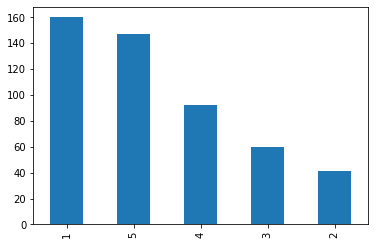

In [8]:
google['score'].value_counts().plot(kind = 'bar')

In [10]:
def convertScore(score):
  if score >= 4:
    return 'good'
  elif score == 3:
    return 'soso'
  else:
    return 'bad'

google['status'] = google['score'].map(lambda e: convertScore(e))

In [11]:
google.head()

,username,score,comment,status
0,倪依芙,5,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...,good
1,Mimi龍,4,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...,good
2,林昌逸,1,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡,bad
3,林幸蓁,5,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...,good
4,台灣TAXI市區叫車禮車包車約拍找小鄭,5,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...,good


In [15]:
import jieba
corpus = []
tags = []
for idx, rec in google[google['status'].isin(['good', 'bad'])].iterrows():
  corpus.append(' '.join(jieba.cut(rec.get('comment'))))
  tags.append(rec.get('status'))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.954 seconds.
Prefix dict has been built successfully.


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)

In [17]:
x = tfidf
y = tags

In [18]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [19]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha = 0.01)
clf1.fit(train_x, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [20]:
from sklearn.svm import SVC
clf2 = SVC(kernel = 'linear')
clf2.fit(train_x, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
pred_y = clf1.predict(test_x)

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, pred_y)

0.8181818181818182

In [25]:
from sklearn.metrics import confusion_matrix
print(clf1.classes_)
confusion_matrix(test_y, pred_y)

['bad' 'good']


array([[30, 10],
       [ 6, 42]])

In [26]:
features_ary = []
for word, bad_count, good_count in zip(vectorizer.get_feature_names(), clf1.feature_count_[0], clf1.feature_count_[1]):
  dic = {}
  dic['good_ratio'] = good_count/(bad_count + 1)
  dic['bad_ratio'] = bad_count / (good_count + 1)
  dic['good_cnt'] = good_count
  dic['bad_cnt'] = bad_count
  dic['word'] = word
  features_ary.append(dic)

In [27]:
import pandas
features_df = pandas.DataFrame(features_ary)

In [30]:
features_df.sort_values('good_ratio', ascending=False).head(10)

,good_ratio,bad_ratio,good_cnt,bad_cnt,word
971,4.432004,0.155759,16.540930,2.732156,好吃
12,4.281420,0.016871,4.692600,0.096038,24
1041,4.281420,0.016871,4.692600,0.096038,小時
2189,4.264247,0.018926,4.726398,0.108378,親切
973,4.072805,0.049346,5.348771,0.313289,好喝
2050,3.478154,0.067243,4.845260,0.393055,美味
2053,3.343670,0.026732,3.770038,0.127515,美食
2606,3.150396,0.073043,4.390926,0.393770,飲料
340,3.121750,0.085690,4.626977,0.482174,乾意
302,3.112518,0.115085,5.407819,0.737442,不錯


In [31]:
features_df.sort_values('bad_ratio', ascending=False).head(10)

,good_ratio,bad_ratio,good_cnt,bad_cnt,word
1247,0.129321,3.228117,0.938621,6.258093,態度
1004,0.101876,2.808830,0.543576,4.335644,客人
1130,0.000000,2.552051,0.000000,2.552051,店員態度
1439,0.050667,2.548792,0.206472,3.075046,普通
1924,0.049725,2.343325,0.188173,2.784275,知道
1974,0.000000,2.227581,0.000000,2.227581,第二次
293,0.051669,2.202086,0.186692,2.613197,不要
2483,0.000000,2.158271,0.000000,2.158271,重點
270,0.155664,2.059802,0.701101,3.503932,不會
2155,0.000000,2.035631,0.000000,2.035631,蟑螂


In [32]:
pred_y = clf2.predict(test_x)

In [33]:
accuracy_score(test_y, pred_y)

0.875

In [34]:
confusion_matrix(test_y, pred_y)

array([[33,  7],
       [ 4, 44]])

## Synset

In [36]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
from nltk.corpus import wordnet as wn
wn.synsets('motorcar')

[Synset('car.n.01')]

In [39]:
wn.synsets('trunk')

[Synset('trunk.n.01'),
 Synset('trunk.n.02'),
 Synset('torso.n.01'),
 Synset('luggage_compartment.n.01'),
 Synset('proboscis.n.02')]

In [40]:
wn.synset('car.n.01').lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

## 計數手法

In [62]:
a = '''
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M




'''

print(a.replace('\xa0', ' '))


def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M







In [46]:
import numpy as np
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [48]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [50]:
word_to_id

{'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}

In [51]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [53]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [54]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
vocab_size

7

In [56]:
print(word_to_id.keys())
C = create_co_matrix(corpus, vocab_size)
C

dict_keys(['you', 'say', 'goodbye', 'and', 'i', 'hello', '.'])


array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [59]:
from sklearn.metrics.pairwise import cosine_similarity
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1. 列出Query
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    print('[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2. 計算Cosine Similarity
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cosine_similarity([word_matrix[i], query_vec])[1,0]
        
    # 3. 從cosine similarity 由高到低列出數值結果
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        count += 1
        if count >= top:
            return


In [60]:
most_similar('you', word_to_id, id_to_word, C, top=5)

[query] you
 goodbye: 0.7071067811865475
 i: 0.7071067811865475
 hello: 0.7071067811865475
 say: 0.0
 and: 0.0


In [61]:
most_similar('i', word_to_id, id_to_word, C, top=5)

[query] i
 goodbye: 0.9999999999999998
 you: 0.7071067811865475
 hello: 0.4999999999999999
 say: 0.0
 and: 0.0


In [63]:
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [64]:
W = ppmi(C)

In [65]:
W

array([[0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [1.8073549, 0.       , 0.8073549, 0.       , 0.8073549, 0.8073549,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.8073549, 0.       , 1.8073549, 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 0.       , 0.       , 0.       ,
        2.807355 ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 2.807355 ,
        0.       ]], dtype=float32)

In [66]:
W.shape

(7, 7)

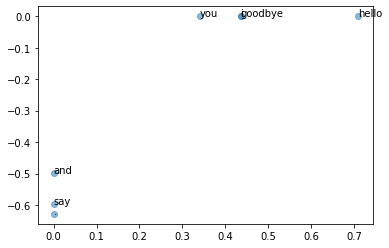

In [68]:
# SVD
U, S, V = np.linalg.svd(W)

# 繪製相對位置圖
from matplotlib import pyplot as plt
for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

## 推論手法

In [69]:
ary = ['a', 'b', 'c', 'a']
ary2 = [[1,0,0],
        [0,1,0],
        [0,0,1],
        [1,0,0]]

In [70]:
import numpy as np
x = np.array([1,0,0,0,0,0,0])
w = np.random.randn(7,3)

In [71]:
w

array([[-0.11363084, -2.28101701,  0.18182318],
       [-0.81678917,  0.07047548, -0.49374246],
       [ 0.29786418, -0.48846946,  1.46198112],
       [-0.2348319 , -0.48053544,  0.09889525],
       [-0.86271921,  0.80345856, -0.57753841],
       [-0.04079934,  0.02185637, -0.64610181],
       [-0.272597  ,  0.37954465, -0.29845536]])

In [72]:
np.dot(x,w)

array([-0.11363084, -2.28101701,  0.18182318])

## Gensim

In [87]:
from gensim.models import word2vec
text = 'You say goodbye and I say hello .'

In [95]:
num_features = 2 # 詞向量的維度
min_word_count = 1 # 最少要出現幾個詞才被拿來計算
num_workers = 1 # 使用多少個core
context = 1 # 上下文的詞區間
epoch = 200 # 訓練多少迭代 
sample = 1e-5 # 每次要取多少反面的例子校正訓練結果
model = word2vec.Word2Vec([text.split()], 
  workers = num_workers,
  sample = sample,
  size = num_features,
  min_count=min_word_count,
  window = context,
  iter = epoch)


In [96]:
for ele in model.wv.vocab:
  print(ele)

You
say
goodbye
and
I
hello
.


In [97]:
X = model.wv.vectors

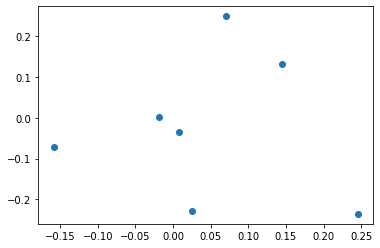

In [98]:
from matplotlib import pyplot as plt
plt.scatter(X[:,0], X[:,1])

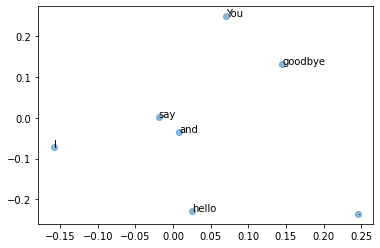

In [99]:
# 繪製相對位置圖
from matplotlib import pyplot as plt
for vocab, vec in zip(model.wv.vocab, model.wv.vectors):
  plt.annotate(vocab, (vec[0], vec[1]))
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

In [100]:
import pandas
df = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/tibame_tm/master/data/yahoo_movie.xlsx', index_col=0)

In [101]:
df.head()

,content,stars,title,status
0,"不知道耶! 看完整個無感\r\n有種覺得就是女兒""給蕭""害死了老爸\r\n然後...既然可以...",3,古墓奇兵,soso
1,很好看的動作片，不會浪費錢跟時間。很久沒有這樣的探險片。可說是女版的印第安那瓊。女主角跟爸爸...,5,古墓奇兵,good
2,說這個不好看的話，那我還真不知道，還有什麼片是您可以去看得了。電影好看，但話說羅拉有裝可以撿...,5,古墓奇兵,good
3,父女重逢真的很讓人感動，五顆星。,5,古墓奇兵,good
4,劇情雖然老套，但仍拍出新意，古墓能殺人的方式不就是機關和毒，要求亂七八糟的觀眾，你看喪尸片看多了。,4,古墓奇兵,good


In [104]:
corpus = []
for e in df['content'].tolist():
    corpus.append(list(jieba.cut(e)))

In [193]:
size = 50  # 產生多少維度 
min_count = 5 # 要算至少出現多少次數的字詞
workers = 1 # 使用多少個core 計算, -1 使用所有的core 進行計算 
window = 10  # 上下文的區間
iter = 300 # 神經網路訓練的迭代數
sample = 1e-5 # 取樣的數量
model = word2vec.Word2Vec(corpus, 
                          workers = workers,
                          sample = sample,
                          size = size,
                          min_count=min_count,
                          window = window,
                          iter = iter)

In [194]:
#for ele in model.wv.vocab:
#  print(ele)

In [195]:
model.wv.most_similar('👍')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('十足', 0.9897077083587646),
 ('果然', 0.9894537329673767),
 ('值得', 0.9892654418945312),
 ('突然', 0.9888033270835876),
 ('滿', 0.9886372089385986),
 ('小時', 0.9866103529930115),
 ('必須', 0.9858665466308594),
 ('其他', 0.9854885339736938),
 ('更是', 0.9849401712417603),
 ('古墓', 0.984939694404602)]

In [196]:
model.wv.get_vector('👍')

array([ 0.07338532,  0.18609293, -0.25074428, -0.18633991, -0.28603992,
        0.06579739, -0.35896015, -0.32527345,  0.38949713, -0.05569847,
       -0.07832443,  0.13120978,  0.03734408, -0.22170375,  0.12236812,
       -0.11746839,  0.18363419,  0.0672162 , -0.26822218, -0.31268165,
       -0.04810975, -0.19600324, -0.09577873,  0.05476827, -0.22721924,
        0.11742287, -0.21671477, -0.10098772,  0.01831993, -0.2445491 ,
       -0.13706177,  0.07400527,  0.36488894, -0.07196474,  0.00214831,
        0.09786694,  0.09303434, -0.09117038,  0.11472452, -0.20006587,
        0.11969557,  0.20175466, -0.06208754,  0.19190007, -0.281845  ,
        0.07629075, -0.45043802, -0.40760112, -0.0823594 , -0.13863821],
      dtype=float32)

In [197]:
import jieba
corpus = []
tags = []
for idx,rec in df[df['status'].isin(['good', 'bad'])].iterrows():
  corpus.append(list(jieba.cut(rec.get('content'))))
  tags.append(rec.get('status'))


In [198]:
#corpus[0]

In [200]:
size = 50
cnt = 0
vec = np.zeros(size).reshape((1, size))
print(vec.shape)
for word in corpus[0]:
  try:
    #print(model.wv.get_vector(word))
    vec += model.wv.get_vector(word)
    cnt += 1
  except:
    pass
vec / cnt

(1, 50)


array([[ 0.10855088,  0.3540951 , -0.4293506 , -0.28519696, -0.39897223,
         0.13979747, -0.33643991, -0.39887722,  0.30689265, -0.12167805,
        -0.16278718,  0.10810256,  0.08917099, -0.17198335, -0.12132943,
        -0.15653738,  0.19590032,  0.18702446, -0.19592552, -0.34704248,
         0.07140403, -0.0271785 , -0.08992481,  0.14574412, -0.28350126,
         0.11792511, -0.15592171, -0.18897898, -0.00095905, -0.50300532,
        -0.19894025,  0.22852961,  0.51757399, -0.13414314,  0.15066232,
         0.06935868,  0.10653155, -0.12389471,  0.2044886 , -0.09038146,
        -0.08674541,  0.25462777, -0.19100132,  0.03184937, -0.52727642,
         0.26277817, -0.43703116, -0.49429352, -0.03688893, -0.37129146]])

In [215]:
import numpy as np
vecs = []
for s in corpus:
    vec = np.zeros(size).reshape((1, size))
    cnt = 0
    for w in s:
        if w in model:
            #print(w, model[w])
            vec += model[w].reshape((1, size))
            cnt += 1
    vecs.append(vec / cnt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [216]:
len(vecs)

980

In [203]:
X = np.concatenate(vecs, axis = 0)

In [208]:
X.fill(0)

In [209]:
X.shape

(980, 50)

In [210]:
# 建立訓練與測試資料集
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, tags, test_size = 0.2, random_state = 42)

In [217]:
# 建立模型
from sklearn.svm import SVC
clf = SVC(kernel = 'linear')
clf.fit(train_X, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [218]:
pred_y = clf.predict(test_X)

In [219]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y,pred_y)

0.5867346938775511

In [220]:
confusion_matrix(test_y,pred_y)

array([[  0,  81],
       [  0, 115]])

In [221]:
#! gdown https://drive.google.com/file/d/1tj0fszpULth9L2F2yVqRKmRAHi8xD_uc/view
! gdown https://drive.google.com/uc?id=1tj0fszpULth9L2F2yVqRKmRAHi8xD_uc

Downloading...
From: https://drive.google.com/uc?id=1tj0fszpULth9L2F2yVqRKmRAHi8xD_uc
To: /content/zh_wiki_word2vec_300.zip
888MB [00:07, 123MB/s] 


In [222]:
! unzip zh_wiki_word2vec_300.zip

Archive:  zh_wiki_word2vec_300.zip
  inflating: zh_wiki_word2vec_300.txt  


In [224]:
from gensim.models import word2vec

In [227]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('zh_wiki_word2vec_300.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [230]:
model.wv.most_similar('貓')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('貍', 0.6560509204864502),
 ('豬', 0.6342272758483887),
 ('貓的', 0.6134812831878662),
 ('貓與', 0.5769718885421753),
 ('隻', 0.5707628726959229),
 ('的貓', 0.564104437828064),
 ('貓和', 0.5567063689231873),
 ('小貓', 0.5559827089309692),
 ('老鼠', 0.553476870059967),
 ('山羊', 0.5511968731880188)]

In [231]:
import jieba
corpus = []
tags = []
for idx,rec in df[df['status'].isin(['good', 'bad'])].iterrows():
  corpus.append(list(jieba.cut(rec.get('content'))))
  tags.append(rec.get('status'))


In [233]:
import numpy as np
vecs = []
size = 300
for s in corpus:
    vec = np.zeros(size).reshape((1, size))
    cnt = 0
    for w in s:
        if w in model:
            #print(w, model[w])
            vec += model[w].reshape((1, size))
            cnt += 1
    vecs.append(vec / cnt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [234]:
X = np.concatenate(vecs, axis = 0)

In [236]:
X.shape

(980, 300)

In [239]:
X.fill(0)

In [240]:
# 建立訓練與測試資料集
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, tags, test_size = 0.2, random_state = 42)

In [247]:
# 建立模型
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [248]:
pred_y = clf.predict(test_X)

In [249]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y,pred_y)

0.5867346938775511